## Logistic regression with LDP

### Non LDP Logistic regression with sklearn
To set a benchmark to test our eventual implementation on we first take a dataset and feed it to an exisiting LR implementation from the sklearn module.

The dataset to use is the 'Adult' dataset from the UCI repository.

The data needs to be converted into numerical categorical values since we will only use these kinds of datasets in our research.

In [7]:
import pandas as pd
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
from scipy.stats import bernoulli
from pure_ldp.frequency_oracles.direct_encoding import DEClient, DEServer

raw_data = pd.read_csv("./Dataset/adult.data")
raw_data['bias'] = 1
feature_columns = raw_data.columns
epsilon = 4

def tempDataConvertor():
        raw_data = pd.read_csv("../Experiments/Dataset/adult.data")
        continuous_features = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
        continuous_data = _convert_continuous_data(raw_data[continuous_features])
        discrete_features = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
        temp_data = pd.concat([continuous_data, raw_data[discrete_features]], axis=1)
        discrete_data = _convert_discrete_data(temp_data)
        Xs = discrete_data.loc[:, 'age':'native-country']
        y = _convert_discrete_data(raw_data.loc[:,['income']], features=['income'])
        return train_test_split(Xs, y, test_size=0.2, random_state=42)

def _perturb_test(Xs, features, epsilon=4):
    servers = []
    for feature in features:
        d = max(Xs[feature].unique())+1
        DEClientClassification = DEClient(epsilon=epsilon, d=d)
        DEServerClassification = DEServer(epsilon=epsilon, d=d)
        Xs[feature] = Xs[feature].apply(lambda x: DEClientClassification.privatise(x+1))
        Xs[feature].apply(lambda item : DEServerClassification.aggregate(item))
        servers.append(DEServerClassification)
    return servers
    
def _convert_discrete_data(data, features=None):
    if features == None:
        features = data.columns

        for feature_name in features:
            data[feature_name] = pd.Categorical(data[feature_name])
            data[feature_name] = data[feature_name].cat.codes
    else:
        data[features[0]] = pd.Categorical(data[features[0]])
        data = data[features[0]].cat.codes

    return data

def _convert_continuous_data(data):
    features = data.columns
    continuous_data = data[features].copy()
    for feature in features:
        continuous_data.loc[:,feature] = pd.qcut(continuous_data[feature], q=10, labels=False, duplicates="drop")
    return continuous_data

X_train, X_test, y_train, y_test = tempDataConvertor()

servers_features = _perturb_test(X_train, X_train.columns, epsilon)

col = 1
classUnique, classCounts = np.unique(X_train.iloc[:,col], return_counts=True)
print("The counts of each possibile value of the classifications:\n",dict(zip(classUnique+1,classCounts)))
print(servers_features[col].estimate(1))

The counts of each possibile value of the classifications:
 {1: 2615, 2: 2601, 3: 2511, 4: 2672, 5: 2580, 6: 2637, 7: 2642, 8: 2576, 9: 2640, 10: 2574}
2616.903050757105


### Applying sklearn
We import the sklearn logistic regression classifier.



Text(0.5, 1.0, 'Accuracy Score: 0.8088438507600184')

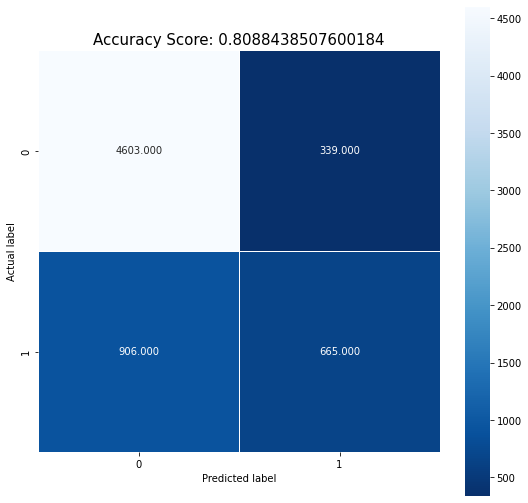

In [2]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

LRClassifier = LogisticRegression(max_iter=200).fit(X_train, y_train)
predictions = LRClassifier.predict(X_test)
score = LRClassifier.score(X_test,y_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

### Change of plans
Because it is not possible to use frequency estimation with logistic regression, we have decided to try another solution.
This involves a different perturbation scheme that we will first need to get working an test it's effectiveness.
The second step is to test if we can make a gradient descent algorithm were the users calculate the gradient and we take a mean of their values to adjust our weights.
The last step is to incorporate the two into one algorithm

### First part: Perturbation scheme with LaPlacian noise
The first perturbation scheme is the simplest one. It is taken from a paper by Ning Wang called: "Collecting and Analyzing Multidimensional Data
with Local Differential Privacy"

The general idea of the perturbation scheme:

We have a `epsilon` value the indicates the amount of privacy.

The user provided data `t` has a range of [-1,1].

To perturb `t` into `t*` we perform the following function: `t + Lap(2/epsilon)`. The `Lap(x)` indicates a LaPlace random variable with scale `x`. To do this in python we use numpy.random.laplace

The aggregator can estimate the mean by a simple average calculation: `1/n Sum(t*)`

Let's try this in python.

In [3]:
# Perturbs a single value
def laplacePerturb(t, epsilon=2):
    return t + np.random.laplace(scale=2/epsilon)

laplacePerturb(-0.5)

0.26887449481657166

Now for the aggregator function.

It is simply a function that takes the mean of the data. So there is no compensation for added noise.

In [4]:
def aggregateMean(data):
    n = len(data)
    return (1/n * np.sum(data, axis=0))

testSet = np.array([random.uniform(-1,1) for i in range(1000)])
perturbedTestSet = [laplacePerturb(i, epsilon=0.5) for i in testSet]
print("No perturbation: ",aggregateMean(testSet))
print("With perturbation: ", aggregateMean(perturbedTestSet))

No perturbation:  0.030646463069936406
With perturbation:  0.38044782870137933


### Conclusion first part
The perturbation scheme with LaPlacian noise is easy to implement.

The drawbacks that are also mentioned in the paper are that this method is extremely simple and does not perform well for lower epsilon values. 

What should also be noted is that the sign value of the mean is not always correctly estimated. So when the mean value get's close to 0 the estimate might have a different sign (-/+) than the actual mean. When passing a gradient this means that the step taken to correct the weights will be in the wrong direction.

### Second part: gradient descent with passed gradient values
For this we need to construct a simple gradient descent algorithm and prove it works correcty. 

For this we require some functions:

- A sigmoid function to make the prediction have a value between 0 and 1
- A prediction function using that uses the user data and the given weights to make a prediction
- A function to calculate the gradient at the user using their data.
- A function that aggregates the gradients and performs a single gradient descent step.

In [5]:
def stable_sigmoid(x):
    sig = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return sig

def predict(X_data, weights):
    return stable_sigmoid(np.dot(X_data, weights))

# X and y data are considered a single row of data
def calculateGradient(X_data, y_data, weights):
    prediction = predict(X_data, weights)
    gradient = np.dot((prediction - y_data),X_data)
    # Clip the value of the gradient to fit [-1,1]
    clippedGradient = [np.clip(g, -1, 1) for g in gradient]
    return clippedGradient

def singleGradientDescentStep(gradients, weights, learningRate):
    return weights - learningRate * np.array(gradients)

# Some test data
X_data = [[np.random.choice(np.arange(1, 7), p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2]) for i in range(3)]for j in range(50)]
y_data = [1 if X_data[i][2] > 4 else 0 for i in range(50)]
weights = [random.random() for i in range(3)]
learningRate = 0.01
gradient = calculateGradient(X_data[0], y_data[0], weights)
print("Checking the gradient calculation goes correct:")
print("X: ",X_data[0])
print("weights: ", weights)
print("Predict: ",predict(X_data[0], weights))
print("Actual y: ", y_data[0])
print("Prediction - y: ", predict(X_data[0], weights) - y_data[0])
print("Gradient calculation - X times error: ", gradient)

meanGradient = 1/len([gradient]) * np.sum([gradient], axis=0)
learnGradient = meanGradient * learningRate
print("\nChecking the gradient descent step goes correct:")
print("Mean gradient:", meanGradient)
print("Mean gradient times learning rate: ", learnGradient)
print("Update weights manualy:\t\t ", np.array([weight - learnGradient[i] for i, weight in enumerate(weights)]))
print("Single gradient descent step:\t ",singleGradientDescentStep(gradient, weights, learningRate))

Checking the gradient calculation goes correct:
X:  [3, 4, 6]
weights:  [0.2068188473978918, 0.2927230528206186, 0.09818026295561078]
Predict:  0.9153227939021188
Actual y:  1
Prediction - y:  -0.08467720609788121
Gradient calculation - X times error:  [-0.2540316182936436, -0.33870882439152483, -0.5080632365872872]

Checking the gradient descent step goes correct:
Mean gradient: [-0.25403162 -0.33870882 -0.50806324]
Mean gradient times learning rate:  [-0.00254032 -0.00338709 -0.00508063]
Update weights manualy:		  [0.20935916 0.29611014 0.1032609 ]
Single gradient descent step:	  [0.20935916 0.29611014 0.1032609 ]


### Questions
Now that we have tried something with a value of a single user, we can perform a single step for 50 values for example. The mean gradient is different and should nudge the weights into a more general prediction. 

This however is still one step in gradient descent. We need to perform this many more times. Does this mean we have to ask the user to give us an updated value for their gradient at each step of the gradient descent? Or are we reusing the gradient values based on the first set of weight? That does not sound logicall because it would move us into one direction until the max iterations are hit or we hit a minimum. But if the initial step is incorrect, we drift further away from the minimum. So it look like there needs to be some sort of update.

We need to pass the gradient but this needs to be a value between [-1, 1] because of our perturbation algorithm. Answer: We clip the value of the gradient to be between -1 and 1.

### Third part: 'sending' user perturbed gradients and use that in gradient descent
So for the last part we need to combine the two previous steps.

We start by calculating the gradients with a given weight. 

Next we perturb the gradient

At the server these are aggregated and a mean value is taken for each feature.

The last step is the gradient descent algorithm

The laplace mean gradient:	  [ 0.51  0.69  0.69  0.04 -0.13  0.65  0.84  0.75  0.71  0.7   0.54  0.68
  0.55  0.67]
The actual gradient:		  [0.61 0.67 0.64 0.   0.   0.61 0.73 0.72 0.66 0.71 0.53 0.73 0.52 0.74]
Original weights:
  [0.105 0.908 0.229 0.037 0.085 0.393 0.324 0.706 0.685 0.994 0.702 0.366
 0.118 0.197]
Updated weights after a single gradient descent step:
  [0.1   0.901 0.222 0.036 0.086 0.386 0.315 0.698 0.678 0.987 0.697 0.359
 0.112 0.191]


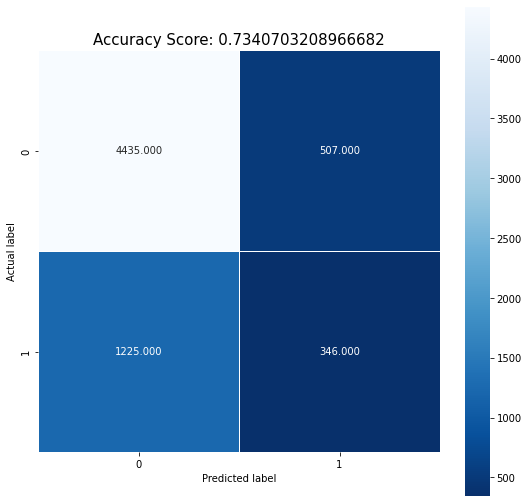

In [6]:
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn import metrics

startWeights = [random.random() for i in range(X_train.shape[1])]
testGradient = [calculateGradient(X_train.iloc[i,:], y_train.iloc[i], startWeights) for i in range(100)]

perturbedData = [[laplacePerturb(gradient, epsilon=epsilon) for gradient in testGradient[j]] for j in range(len(testGradient))]

aggregatedMean = aggregateMean(perturbedData)
print("The laplace mean gradient:\t ", np.round(aggregatedMean, 2))
print("The actual gradient:\t\t ", np.round(1/len(testGradient) * np.sum(testGradient, axis=0),2))

newWeights = singleGradientDescentStep(aggregatedMean, startWeights, learningRate)
print("Original weights:\n ", np.round(startWeights,3))
print("Updated weights after a single gradient descent step:\n ", np.round(newWeights,3))

def clientActor(weights):
    testGradient = [calculateGradient(X_train.iloc[i,:], y_train.iloc[i], weights) for i in range(100)]
    return [[laplacePerturb(gradient, epsilon=epsilon) for gradient in row] for row in testGradient]

def fullGradientDescent(initialWeights, iterations=50, learningRate=0.1, threshold=0.005):
    weights = initialWeights
    previousWeights = [w+threshold*2 for w in weights]
    for i in range(iterations):
        perturbedData = clientActor(weights)
        mean = aggregateMean(perturbedData) # The mean for each feature gradient
        weights = singleGradientDescentStep(mean, weights, learningRate)
        diff = max(np.absolute(weights-previousWeights))
        previousWeights = weights
        if diff < threshold:
            return weights
    return weights
        
newWeights = fullGradientDescent(startWeights, iterations=200, learningRate=5)
results = [np.round(predict(X_test.iloc[i,:], newWeights)) for i in range(X_test.shape[0])]

cm = metrics.confusion_matrix(y_test, results)
score = accuracy_score(y_test, results)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Testing other LDP mechanisms
The paper descibes other LDP mechanism. Let's see how they estimate the mean value of the given data.

First Duchi et al.'s implementation:

The input has a domain of [-1,1]

The output has a domain of {- (e^epsilon +1) / (e^epsilon - 1), (e^epsilon +1) / (e^epsilon - 1)}

The aggregate is again a simple average calculation.

In [92]:
def duchiPerturb(t, epsilon=2):
    cons = (math.pow(math.e, epsilon) + 1) / (math.pow(math.e, epsilon) - 1)
    p = ((math.pow(math.e, epsilon) - 1) / (2 * (math.pow(math.e, epsilon) + 1))) * t + (1/2)
    u = bernoulli.rvs(p, size=1)
    if u:
        return cons
    else:
        return -cons

testSet = np.array([random.uniform(-1,1) for i in range(100000)])
perturbedTestSet = [duchiPerturb(i, epsilon=1) for i in testSet]
print("No perturbation: ",aggregateMean(testSet))
print("With perturbation: ", aggregateMean(perturbedTestSet))

-10.033311132253989


Second is the Piecewise Mechainsm for one-dimensional numerical data

The input has a domain of [-1,1]

We sample a random value for `x` from domain [0,1].

If `x < (e^(epsilon/2)) / (e^(epsilon/2) + 1)` select a value from [l(t), r(t)]

else select a value from [-C, l(t) U r(t), C]

In [154]:
def piecewisePerturb(t, epsilon=2):
    x = np.random.uniform(0,1)
    checkValue = (math.exp(epsilon/2)) / (math.exp(epsilon/2) + 1)
    C = (math.exp(epsilon / 2) + 1) / (math.exp(epsilon / 2) - 1)
    lt = ((C + 1) / 2) * t - ((C - 1) / 2)
    rt = lt + C - 1
    if x < checkValue:
        return np.random.uniform(lt, rt)
    else:
        temp = np.random.uniform(-C, C)
        while temp >= lt and temp <= rt:
            temp = np.random.uniform(-C, C)
        return temp
        
testSet = np.array([random.uniform(-1,1) for i in range(100000)])
perturbedTestSet = [piecewisePerturb(i, epsilon=10) for i in testSet]
print("No perturbation: ",aggregateMean(testSet))
print("With perturbation: ", aggregateMean(perturbedTestSet))

No perturbation:  -0.0026644289116047972
With perturbation:  -0.0027926625100338255
